<a href="https://colab.research.google.com/github/AsutoshDalei/Deep-Neural-Networks/blob/master/COVID19_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID 19 India dataset
#### This dataset is provided by https://www.covid19india.org/
Here, we attempt to understand how the number of Coronavirus cases increased in India and develop a model capable of predicting the future trend in number of cases.

An intresting point here would be to note how India is on it's way in flattening the curve.

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import minmax_scale, MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import files
import io

uploaded = files.upload()

Saving covidindia.csv to covidindia (1).csv


In [0]:
df=pd.read_csv(io.BytesIO(uploaded['covidindia.csv']))
df.head(10)

,Patient Number,State Patient Number,Date Announced,Estimated Onset Date,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1,KL-TS-P1,30/01/2020,NaN,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,2,KL-AL-P1,02/02/2020,NaN,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
2,3,KL-KS-P1,03/02/2020,NaN,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan
3,4,DL-P1,02/03/2020,NaN,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,DL,Recovered,"Travelled from Austria, Italy",NaN,India,Imported,15/03/2020,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,NaN,Travel history to Italy and Austria
4,5,TS-P1,02/03/2020,NaN,24,M,Hyderabad,Hyderabad,Telangana,TG,Recovered,"Travelled from Dubai to Bangalore on 20th Feb,...",NaN,India,Imported,02/03/2020,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,"Travel history to Dubai, Singapore contact"
5,6,NaN,03/03/2020,NaN,69,M,Jaipur,Italians*,Rajasthan,RJ,Recovered,Travelled from Italy,NaN,Italy,Imported,03/03/2020,https://indianexpress.com/article/india/corona...,https://economictimes.indiatimes.com/news/poli...,https://twitter.com/PTI_News/status/1240878975...,Italian tourist
6,7,NaN,04/03/2020,NaN,55,NaN,Gurugram,Italians*,Haryana,HR,Recovered,Travelled from Italy,P6,Italy,Imported,29/03/2020,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,NaN,Italian tourist
7,8,NaN,04/03/2020,NaN,55,NaN,Gurugram,Italians*,Haryana,HR,Recovered,Travelled from Italy,P6,Italy,Imported,29/03/2020,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,NaN,Italian tourist
8,9,NaN,04/03/2020,NaN,55,NaN,Gurugram,Italians*,Haryana,HR,Recovered,Travelled from Italy,P6,Italy,Imported,29/03/2020,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,NaN,Italian tourist
9,10,NaN,04/03/2020,NaN,55,NaN,Gurugram,Italians*,Haryana,HR,Recovered,Travelled from Italy,P6,Italy,Imported,29/03/2020,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,NaN,Italian tourist


**We are focussing only on the number of cases in the entire country**

In [0]:
cols=['Nationality','Detected State','Current Status','Type of transmission']
for i in range(len(cols)):
  print('Unique instances in '+cols[i]+':')
  print(pd.unique(df[cols[i]]))
  print()

Unique instances in Nationality:
['India' 'Italy' 'Canada' 'United Kingdom' 'Phillipines' 'Indonesia' nan
 'Thailand' 'United States of America' 'Tibet' 'Malaysia' 'Myanmar']

Unique instances in Detected State:
['Kerala' 'Delhi' 'Telangana' 'Rajasthan' 'Haryana' 'Uttar Pradesh'
 'Ladakh' 'Tamil Nadu' 'Jammu and Kashmir' 'Karnataka' 'Maharashtra'
 'Punjab' 'Andhra Pradesh' 'Uttarakhand' 'Odisha' 'Puducherry'
 'West Bengal' 'Chandigarh' 'Chhattisgarh' 'Gujarat' 'Himachal Pradesh'
 'Madhya Pradesh' 'Bihar' 'Manipur' 'Mizoram' 'Goa'
 'Andaman and Nicobar Islands' 'Jharkhand' 'Assam' 'Arunachal Pradesh' nan
 'Tripura' 'Meghalaya']

Unique instances in Current Status:
['Recovered' 'Hospitalized' 'Deceased' 'Migrated']

Unique instances in Type of transmission:
['Imported' 'Local' 'TBD' nan 'Imported ' 'Unknown']



In [0]:
df[df['Date Announced'].isnull()]

,Patient Number,State Patient Number,Date Announced,Estimated Onset Date,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes


### We convert the date provided in our dataset into to a Pandas time stamp format

In [0]:
df1=df[['Patient Number','Nationality','Detected State','Current Status','Type of transmission','Date Announced']]

for i in range(df.shape[0]):
  df1['Date Announced'][i]=pd.to_datetime(df['Date Announced'][i], format='%d/%m/%Y')
df1.set_index('Date Announced',inplace=True)
df1.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,Patient Number,Nationality,Detected State,Current Status,Type of transmission
Date Announced,,,,,
2020-01-30,1,India,Kerala,Recovered,Imported
2020-02-02,2,India,Kerala,Recovered,Imported
2020-02-03,3,India,Kerala,Recovered,Imported
2020-03-02,4,India,Delhi,Recovered,Imported
2020-03-02,5,India,Telangana,Recovered,Imported
2020-03-03,6,Italy,Rajasthan,Recovered,Imported
2020-03-04,7,Italy,Haryana,Recovered,Imported
2020-03-04,8,Italy,Haryana,Recovered,Imported
2020-03-04,9,Italy,Haryana,Recovered,Imported


#### Here we define a column 'ones' beside every instance of our data

In [0]:
df1['ones']=np.ones(df1.shape[0])
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Patient Number,Nationality,Detected State,Current Status,Type of transmission,ones
Date Announced,,,,,,
2020-01-30,1,India,Kerala,Recovered,Imported,1.0
2020-02-02,2,India,Kerala,Recovered,Imported,1.0
2020-02-03,3,India,Kerala,Recovered,Imported,1.0
2020-03-02,4,India,Delhi,Recovered,Imported,1.0
2020-03-02,5,India,Telangana,Recovered,Imported,1.0


### We then resample our data.
#### We obtain two dataframes, 'dfone' and 'dfcu'.
'dfone' contains the number of new cases each day while 'dfcu' contains the total number of cases every single day.

In [0]:
dfone=df1['ones'].resample('D').sum()
dfcu=dfone.cumsum()
dfone.tail(3)

Date Announced
2020-04-24    1408.0
2020-04-25    1835.0
2020-04-26    1607.0
Freq: D, Name: ones, dtype: float64

**Visualizing our newly obtained data**

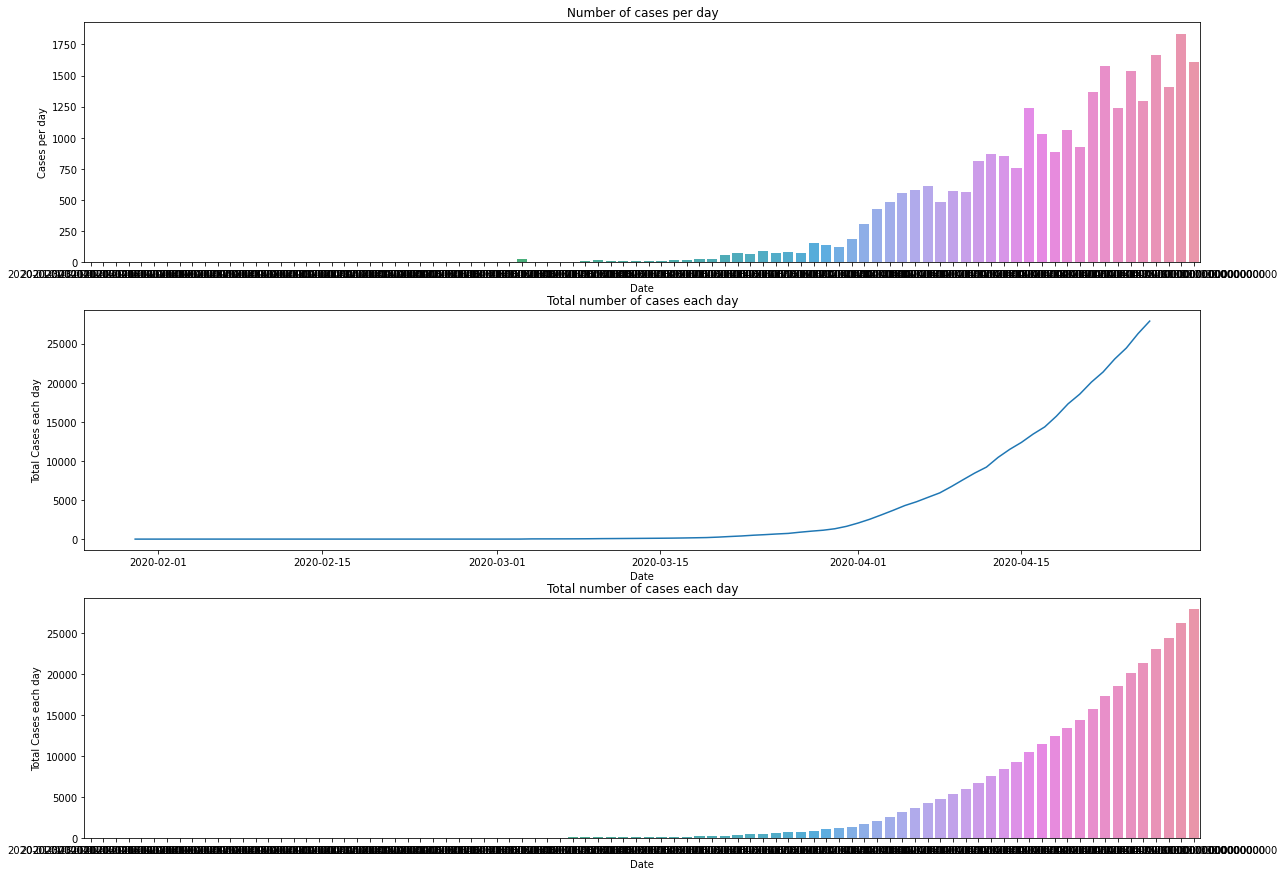

In [0]:
_,_=plt.subplots(figsize=(20,15))
plt.subplot(3,1,1)
sns.barplot(x=dfone.index,y=dfone)
plt.xlabel('Date')
plt.ylabel('Cases per day')
plt.title('Number of cases per day')

plt.subplot(3,1,2)
sns.lineplot(x=dfcu.index,y=dfcu)
plt.xlabel('Date')
plt.ylabel('Total Cases each day')
plt.title('Total number of cases each day')

plt.subplot(3,1,3)
sns.barplot(x=dfcu.index,y=dfcu)
plt.xlabel('Date')
plt.ylabel('Total Cases each day')
plt.title('Total number of cases each day')

plt.show()

**We now prepare our data for training and testing**

We can either consider new cases per day, or cumulative cases each day.

In [0]:
#traindata=dfone.loc[:'2020-04-13']
#testdata=dfone.loc['2020-04-10':]

traindata=dfcu.loc[:'2020-04-13']
testdata=dfcu.loc['2020-04-10':]

#scatraindata=minmax_scale(X=traindata1)
len(testdata)

17

Since we cannot use MinMaxScaler by Scikit on 1D data, we define a function on our own to do so. 

We use the basic formula for scaling:

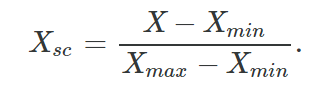

This is followed by defining another functio that would chunk our data into xtrain, ytrain, xtest and ytest resectively


In [0]:
def minmaxsca(data):
  l=[]
  for i in range(len(data)):
    l.append((data[i]-min(data))/(max(data)-min(data)))
  return l

scatraindata=minmaxsca(traindata)
scatestdata=minmaxsca(testdata)

def chunk(data,a):
  x,y=[],[]
  for i in range(a,len(data)):
    x.append(data[i-a:i])
    y.append(data[i])
  return(np.array(x),np.array(y))


In [0]:
testdata

Date Announced
2020-04-10     7600.0
2020-04-11     8454.0
2020-04-12     9212.0
2020-04-13    10455.0
2020-04-14    11486.0
2020-04-15    12372.0
2020-04-16    13433.0
2020-04-17    14355.0
2020-04-18    15726.0
2020-04-19    17306.0
2020-04-20    18545.0
2020-04-21    20082.0
2020-04-22    21374.0
2020-04-23    23041.0
2020-04-24    24449.0
2020-04-25    26284.0
2020-04-26    27891.0
Freq: D, Name: ones, dtype: float64

**We reshape our xtrain since LSTM model take 3D arrays as inputs**

In [0]:
xtrain,ytrain=chunk(scatraindata,3)
xtrain=xtrain.reshape(72,3,1)
print(xtrain.shape)
ytrain.shape

(72, 3, 1)


(72,)

**Defining a LSTM model here**

In [0]:
model=tf.keras.Sequential([
                           tf.keras.layers.LSTM(units=50,activation='relu',return_sequences=True,input_shape=(xtrain.shape[1],1)),
                           tf.keras.layers.LSTM(units=60,activation='relu',return_sequences=True),
                           tf.keras.layers.LSTM(units=80,activation='relu'),
                           tf.keras.layers.Dense(units=1)
                          ])

In [0]:
model.compile(optimizer='adam',loss='mean_squared_error')
hist=model.fit(xtrain,ytrain,epochs=100,batch_size=16)

Epoch 1/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0636
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0589
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0495
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0333
Epoch 11/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 12/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 13/100
5/5 [==============================] - 0s 5ms/st

We plot the loss performance of our model.

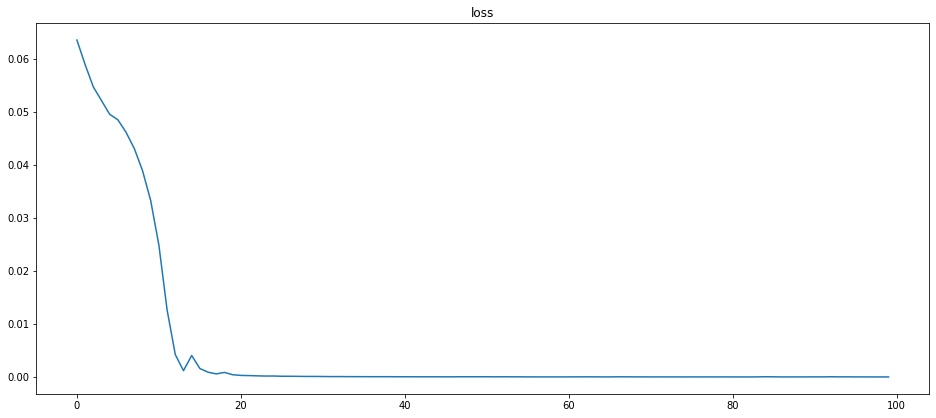

In [0]:
_,_=plt.subplots(figsize=(16,15))
#plt.subplot(1,1,1)
plt.subplot(2,1,1)
plt.title('loss')
plt.plot(hist.history['loss'])

plt.show()

**We also chunk our test data and reshape it into a 3D array**

In [0]:
xtest,ytest=chunk(scatestdata,3)
print(xtest.shape)
print(ytest.shape)

(14, 3)
(14,)


In [0]:
xtest,ytest=np.array(xtest).reshape(14,3,1),np.array(ytest)
ypred=model.predict(xtest)

Plotting our obtained predictions

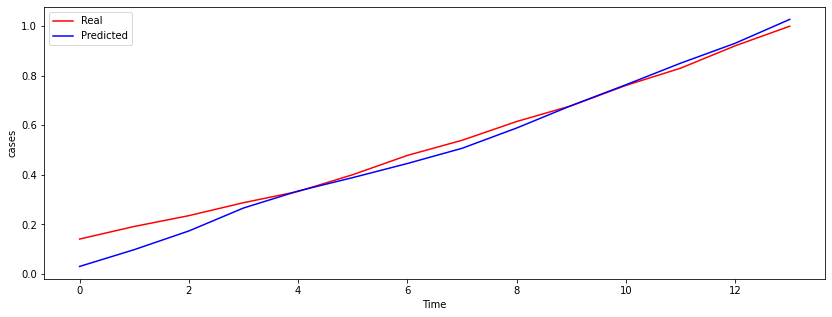

In [0]:
plt.figure(figsize=(14,5))
plt.plot(ytest,color='red',label='Real')
plt.plot(ypred,color='blue',label='Predicted')
#plt.title('Google Opening stock price')
plt.xlabel('Time')
plt.ylabel('cases')
plt.legend()
plt.show()


Since we defined a scaling function, we also have to define an inverse scaling function to better relate with realworld data

In [0]:
def invsca(data,ma,mi):
  l=[]
  for i in range(len(data)):
    l.append((data[i]*(ma-mi))+mi)
  return l
  
invytestpred=invsca(ypred,max(testdata),min(testdata))
invytest=invsca(ytest,max(testdata),min(testdata))

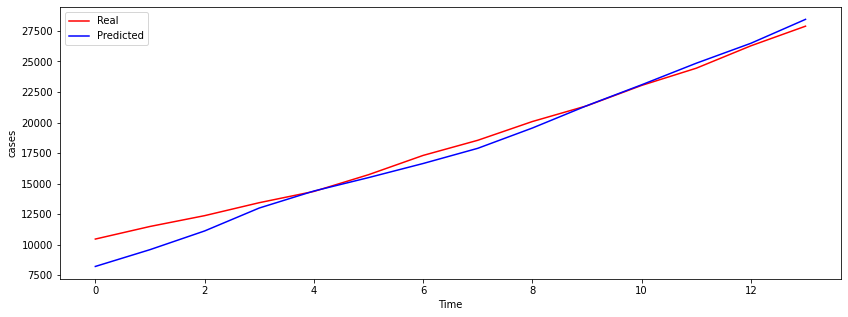

In [0]:
plt.figure(figsize=(14,5))
plt.plot(invytest,color='red',label='Real')
plt.plot(invytestpred,color='blue',label='Predicted')
#plt.title('Google Opening stock price')
plt.xlabel('Time')
plt.ylabel('cases')
plt.legend()
plt.show()


In [0]:
print(len(dfcu.loc['2020-04-13':]))
print(len(invytestpred))

14
14


**We define a DataFrame containing our acquired predicted data and perform necessary modifications**

In [0]:
ypredf=pd.DataFrame(invytestpred)
ypredf.columns=['cases']
#ypredf.index=testdata.loc['2020-04-12':'2020-04-21'	].index
dt = pd.date_range('2020-04-12', periods=14, freq='D')
print(len(dt))
ypredf.index=dt

14


## We finally visualize how our prediction went according to realworld data.

### We can always improve our model and deploy for real world use.

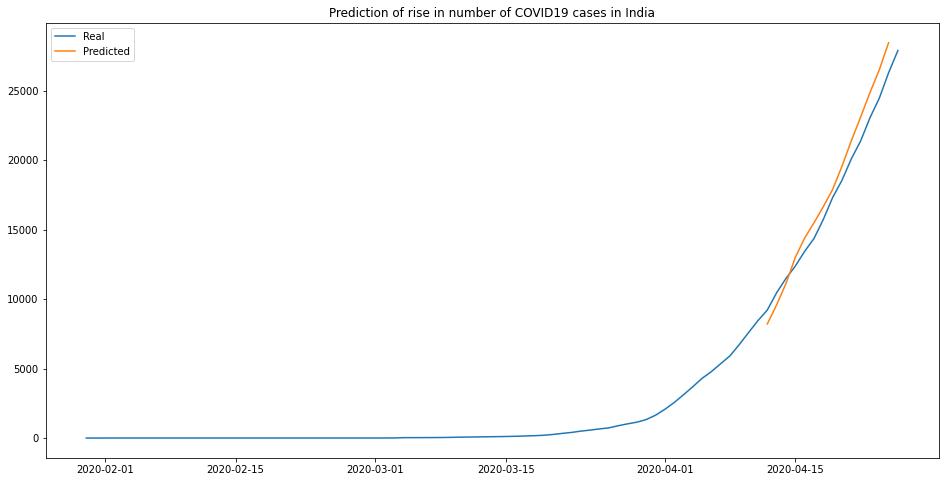

In [0]:
plt.figure(figsize=(16,8))
plt.plot(dfcu, label='Real')
plt.plot(ypredf,label='Predicted')
plt.title('Prediction of rise in number of COVID19 cases in India')
plt.legend()


In [0]:
extx,lul=chunk(ypred,3)
exty=model.predict(extx)

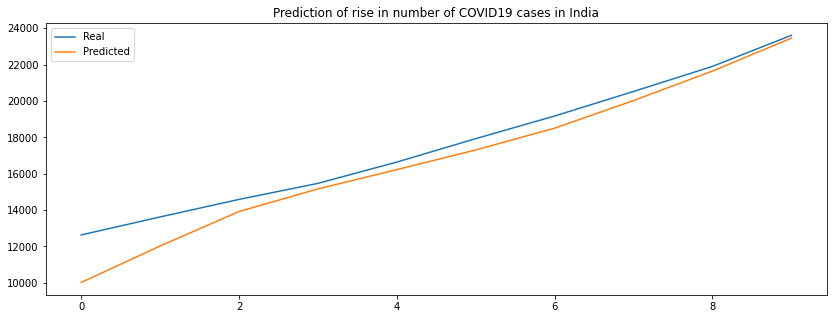

In [0]:
plt.figure(figsize=(14,5))
plt.plot(invsca(lul,max(testdata),min(testdata)), label='Real')
plt.plot(invsca(exty,max(testdata),min(testdata)),label='Predicted')
plt.title('Prediction of rise in number of COVID19 cases in India')
plt.legend()


In [0]:
dt

DatetimeIndex(['2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24'],
              dtype='datetime64[ns]', freq='D')

In [0]:
a=np.array(['bb','aaa','aa','a','b','c','d','e','f','g','h','i','j'])

In [0]:
def chunky(data,a):
  x,y=[],[]
  for i in range(a,len(data)):
    x.append(data[i-a:i])
    y.append(data[i])
  return(np.array(x),np.array(y))

In [0]:
x,y=chunky(a,3)
print(x,y)

[['bb' 'aaa' 'aa']
 ['aaa' 'aa' 'a']
 ['aa' 'a' 'b']
 ['a' 'b' 'c']
 ['b' 'c' 'd']
 ['c' 'd' 'e']
 ['d' 'e' 'f']
 ['e' 'f' 'g']
 ['f' 'g' 'h']
 ['g' 'h' 'i']] ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j']
